In [435]:
import numpy as np
from numpy import sqrt
from numpy import sin
from numpy import pi
from numpy import cos
from numpy import exp
from numpy import tanh
from numpy import zeros
from numpy import arccos
from numpy import log10
from matplotlib import pyplot as plt
import scipy.optimize as opt
import emcee
from pylab import plot
from scipy import integrate
import corner
import random
from collections import Counter
import time
import scipy
from scipy.stats import poisson # use as poisson.pmf(number of events , mean value)
from scipy import optimize
import multiprocessing as mp
from multiprocessing import Pool

import astropy.units as u
import astropy.constants as c
from astropy.cosmology import FlatLambdaCDM, z_at_value
from tqdm import *
from astropy.cosmology import Planck13 as cosmo
from astropy import constants as const

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmasher as cmr
import matplotlib.colors as clrs
import matplotlib.cm as cmap

colors = ['#8a1f1f','#79a43a','#C59D34','#171782', '#cf6717','#ad6faa',
          '#009999','#828282']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

In [436]:
import cmath
# we work in geometrized units
Msol = 1.47680000000000000000000000000000000 # in km
c = 1 # we have actually put them to one everywhere in the code already
G = 1
year = 60*60*24*(365.250000000000000000000000000); # s
cc = 2.9980000000000000000000000000000*10**5 # velocity of light in Km/s
pc = 3.0856770000000000000000000000*10**13 # km

H0 = 67.9 # km /s / Mpc # changed to PLANCK 2015
Omegam = 0.306
OmegaL = 0.694
Omegar = 0.

# some useful functions 
def distL(z):
    return (1+z) * integrate.quad(invE,0,z)[0] *cc / H0 *10**6*pc # km

def Ez(z):
    return sqrt(Omegar*(1+z)**4+Omegam*(1+z)**3+OmegaL)

def invE(z):
    return 1. / Ez(z)

def primopezzo(zp):
    return 1/Ez(zp)*(integrate.quad(invE,0,zp)[0])**2

def dVdz(z):
    return 4*pi*(cc/H0)**3*primopezzo(z) # Mpc**3

def dtdf(f,m1,m2):  # Hz, km, km, gravitational wave frequency
    return 5/(96*pi**(8/3))*(1./cc*(m1 + m2)*(m1*m2/(m1 + m2)**2)**(3/5))**(-5/
  3)*f**(-11/3)  # s^2, assuming f in Hz and m in km

def solof(f):
    return f**(-11/3)

def nu(m1,m2):
    return m1*m2/((m1+m2)**2)

def Mc(m1,m2):
    return (m1 + m2) * (m1*m2/((m1+m2)**2))**(3/5)

In [437]:
# Some other useful functions for frequencies, time of merger, ecc 

# frequency functions 

def fMIN2(fmax0,m1,m2,Tobs): # gravitational wave frequency
    return 1/(1/fmax0**(8/3)+256/5*(Mc(m1,m2)/cc)**(5/3)*pi**(8/3)*(Tobs))**(3/8)

def fmax(m1,m2,fmin,Tobs): # gravitational wave frequency
    return fmin*((5*cc)/(5*cc-256*fmin**(8/3)*pi**(8/3)*Tobs*Mc(m1,m2)*(Mc(m1,m2)/cc)**(2/3)))**(3/8)


# gives fmax, given fmin and Tobs. If fmax is above 10 Hz, gives 10 Hz instead. frequency is always in Hz

def getfmax(m1,m2,fmin,Tobs): # gravitational wave frequency
    if fMIN2(1,m1,m2,Tobs)>fmin:
        return fmax(m1,m2,fmin,Tobs)
    else: 
        return 1
    
def Tmerger(m1,m2,fmin): # gravitational wave frequency
    return 5. * (m1 + m2)**(1./3.) * cc**(5./3.)/ (256. * fmin**(8./3.) * m1 * m2 * pi**(8./3.))

getfmax(13.251739749586237,12.614719123231842,0.07658687835617596,10*year)
Tmerger(29*Msol,36*Msol,0.01)/year


from scipy.optimize import root_scalar
def findFmin(timemerger,m1,m2):
    def condition(fmin):
        return timemerger-Tmerger(m1,m2,fmin)
    return root_scalar(condition,bracket=(10**-4,0.1)).root



In [438]:
#here we want to add also the part with the SNR 

# LISA noise parameters
Amp = 5/10*18/10*10**-44
alpha = 138/1000
beta = -221
kappa = 521
gamma = 1680
fk = 113/10**5
L0 = 25/10*10**9
fstar = 1909/100*10**-3
pm = 10**-12

skyav=(4/5*sqrt(2)*sin(pi/3))

# noise function, checked with Mathematica

def Sacc(f):
    return (3*10**-15)**2*(1+(4/10*10**-3/f)**2)*(1+(f/(8*10**-3))**4)

def Sgal(f):
    return Amp*f**(-7/3)*exp(-f**alpha+beta*f*sin(kappa*f))*(1+tanh(gamma*(fk-f)))

def Soms(f):
    return (15. *pm)**2*(1+(2*10**-3/f)**4)  # noi: 10

def Sacc(f):
    return (3*10**-15)**2*(1+(4/10*10**-3/f)**2)*(1+(f/(8*10**-3))**4)
    
def SnSA(f):
    return 10/3*(4*Sacc(f)/(2*pi*f)**4+Soms(f))/(L0**2)*(1+6/10*(f/fstar)**2)

def R(f):
    return 3/20*2

def Sn(f):
    return abs(SnSA(f)+Sgal(f))

def Pn(f): # gravitational wave frequency
    return abs(Sn(f)*R(f))

def Aplus(iota,psi):
    return -(1+cos(iota)**2)*cos(2*psi)-2*cos(iota)*sin(2*psi)

def Across(iota,psi):
    return (1+cos(iota)**2)*sin(2*psi)-2*cos(iota)*cos(2*psi)

def Fplus(theta,phi):
    return 1/2*(1+cos(theta)**2)*cos(2*phi)

def Fcross(theta,phi):
    return cos(theta)*sin(2*phi)

def factorsky(iota,psi,theta,phi):
    return Fplus(theta,phi)*Aplus(iota,psi)+1j*Fcross(theta,phi)*Across(iota,psi)

def factorskySNR(iota,psi,theta,phi):
    return abs(sqrt(2)*sin(pi/3)*(Fplus(theta,phi)*Aplus(iota,psi)+1j*Fcross(theta,phi)*Across(iota,psi)))


In [439]:
# waveform

def ampl(m1,m2,d): 
    return (Mc(m1,m2)*G)**(5/6)*sqrt(5/24)/(pi**(2/3)*d*c**(3/2))
def habs(m1,m2,d,f): # gravitational wave frequency
    return ampl(m1,m2,d)*f**(-7/6)

#print(habs(12.4913,12.3884,10.8287*10**6*pc,1./cc))

In [440]:
# Here we define the SNR; 
# be careful that I have already put the factor for the sky average
# we use the GW only template.

def SNR(iota,psi,theta,phi,fmin,fmax,m1,m2,d): # gravitational wave frequency
    return sqrt(4*integrate.quad(lambda x: (factorskySNR(iota,psi,theta,phi)*habs(m1,m2,d, x/cc))**2/(Pn(x)*(cc**2)), fmin, fmax)[0])
#different noise here!

def SNRAverage(fmin,fmax,m1,m2,d): # gravitational wave frequency
    return sqrt(4*integrate.quad(lambda x: (skyav*habs(m1,m2,d, x/cc))**2/(Pn(x)*(cc**2)), fmin, fmax)[0])


#print(SNR(pi/4,pi/4,pi/4,pi/4,0.01,fmax(30*Msol,10*Msol,0.01,10*year),60*Msol,10*Msol,400*10**6*pc),400*10**6*pc)
#print(SNR(pi/4,pi/4,pi/4,pi/4,0.01,1,10*Msol,20*Msol,10**23))


In [441]:
eobdata = np.loadtxt('EOBmasses.dat')

NRdata = np.loadtxt('NRmasses.dat')

Phendata = np.loadtxt('PHENmasses.dat')

In [152]:
Phendata

array([[ 94.82355589,  66.75023683],
       [ 94.15420345,  55.51580746],
       [102.70256369,  53.35599928],
       ...,
       [ 98.34671354,  70.28418126],
       [ 72.53043726,  65.99127363],
       [ 91.62076424,  61.80077506]])

In [442]:
def gendistr(N,iteration,massoption,SNRth, which):
    

    N=int(N)
    # Define functions to store intermediate products; I haven't decided on the most convenient format for the final catalogs yet...

    massmin=50*Msol
    massmax=100*Msol

    # Largest horizon redshift; don't waste computing time above this
    zmax = 0.512
    zmin = 0.1
    # Largest comoving distance for sampling
    #??? dove la usa? -->  cdmax=astropy.cosmology.Planck15.comoving_distance(zmax).value # Mpc
    # z pdf normalization. Comoving volume at largest redshift (because comoving volume at z=0 is 0)
    # Vczhor = (astropy.cosmology.Planck15.comoving_volume(zmax)/astropy.units.Gpc**3).decompose().value #Gpc^3
    # largest merger time (yrs)
    tmax = 40
    tobs = 10
    # ground-based duty cycle
    dutycycle= 1

    data=[]
    for i in range(N):

        #Comoving distance uniform on sphere
        #while True:
        #    cd = np.sum(np.random.uniform(0, cdmax,3)**2)**0.5
        #    if cd<cdmax: break
        # Convert to redshift
        #z = astropy.cosmology.z_at_value(astropy.cosmology.Planck15.comoving_distance,cd*astropy.units.Mpc )
        # Convert to luminosity distance


        z = np.random.uniform(zmin,zmax)
        dl = distL(z)

        # Mass spectrum
        if massoption=='log': # Log flat distribution in both masses
            bothm=10**np.random.uniform(np.log10(massmin),np.log10(massmax),2)
            m1= max(bothm)
            m2= min(bothm)
            Rate = 57*10**(-9)
        
        if massoption == 'EOB':
            index = np.random.choice(len(eobdata))
            m1 = Msol*eobdata[index][0]
            m2 = Msol*eobdata[index][1]
            Rate = 0.13*10**(-9)
        
        if massoption == 'PHEN':
            index = np.random.choice(len(Phendata))
            m1 = Msol* Phendata[index][0]
            m2 = Msol*Phendata[index][1]
            Rate = 0.13*10**(-9)
            
        if massoption == 'NR':
            index = np.random.choice(len(NRdata))
            m1 = Msol*NRdata[index][0]
            m2 = Msol*NRdata[index][1]
            Rate = 0.13*10**(-9)
        
        if massoption=='powerlaw': # Power law with spectral index alpha in primary; uniform in secondary
            alpha=-2.3
            m1 = (massmin**(alpha+1.)+np.random.uniform(0.,1.)*(massmax**(alpha+1.)-massmin**(alpha+1.)))**(1./(alpha+1.))
            m2 = np.random.uniform(massmin,m1)
            Rate = 0.13*10**(-9)
                
        # Sky-location, inclination, polarization, initial phase
        cosiota = random.uniform(-1.,1.)
        psi = random.uniform(0,2*pi)
        costheta=random.uniform(-1.,1.)
        phi=random.uniform(0,2*pi)
        iota=np.arccos(cosiota)
        theta=np.arccos(costheta)
        #phic = np.random.uniform(0,2.*np.pi)
        
        # Merger time
        tmerger=np.random.uniform(1*year,41*year)
        
        #fmin=np.random.uniform(1e-5,0.01)
        fmin=findFmin(tmerger,m1,m2)
        Fmax= getfmax(m1*(1+z),m2*(1+z),fmin/(1+z),tobs*year)  #fmax(m1,m2,fmin,tobs*year)
        #Fmax = 1 #Fmax=1
        snr=np.sqrt(dutycycle)*SNR(iota,psi,theta,phi,fmin/(1+z),Fmax,m1*(1+z),m2*(1+z),dl)


        dVcdz = cosmo.comoving_volume(z).value 
        rateSampling = 1 / np.random.gamma(1, 1/ Rate) #np.random.normal(Rate, 0.3e-9)#1 / np.random.gamma(1, 1/ Rate)
        
        if which == 'new':
            integralbulk = rateSampling * tmax * (zmax-zmin) * dVcdz   *np.heaviside(snr-SNRth,0) * (1./(1.+z))
            
        if which == 'old':
            
            integralbulk = tmax * (zmax-zmin) * dVcdz   *np.heaviside(snr-SNRth,0) * (1./(1.+z))

        data.append(np.array([m1,m2,z,fmin,integralbulk,snr]))

    return np.array(data).T



In [87]:
arrayN = np.arange(1,1000, 1)
totry = np.array([1 / np.random.gamma(1, 1/ (0.13*10**(-9))) for n in arrayN])

In [133]:
(10 * year) / np.random.gamma(8, 1/ (0.13*10**(-9))) 

0.005675352427525946

In [66]:
zP = np.random.uniform(0.1,0.512)
dlP = distL(zP)

In [67]:
tmergerP=np.random.uniform(1*year,41*year)

In [68]:
indexP = np.random.choice(len(Phendata))
m1P = Phendata[indexP][0]
m2P = Phendata[indexP][1]

In [15]:
fminP=findFmin(tmergerP,m1P,m2P)

In [443]:
cosiotaP = random.uniform(-1.,1.)
psiP = random.uniform(0,2*pi)
costhetaP=random.uniform(-1.,1.)
phiP=random.uniform(0,2*pi)
iotaP=np.arccos(cosiotaP)
thetaP=np.arccos(costhetaP)

In [17]:
FmaxP=getfmax(m1P*(1+zP),m2P*(1+zP),fminP/(1+zP),6*year)

In [444]:
SNR(iotaP,psiP,thetaP,phiP,fminP/(1+zP),FmaxP,m1P*(1+zP),m2P*(1+zP),dlP)


6.333099331142612

In [445]:
def consolidatedistr(Nsingle,iterations,massoption,SNRth, which):

    Nsingle = int(Nsingle)
    iterations = int(iterations)

    Ntot = Nsingle*iterations
    data=[]
    for it in range(0,iterations):
        data.append(gendistr(Nsingle,it,massoption,SNRth, which))

    data=np.array(data)

    #[m1,m2,z,pdetLIGO,pdetCE,tmerger,SNR4,SNR10,integralbulk]

    m1 = np.concatenate(data[:,0])
    m2 = np.concatenate(data[:,1])
    z = np.concatenate(data[:,2])
    #pdetLIGO = np.concatenate(data[:,3])
    #pdetCE = np.concatenate(data[:,4])
    #tmerger = np.concatenate(data[:,3])
    fmin = np.concatenate(data[:,3])
    #SNR4 = np.concatenate(data[:,6])
    #SNR10 = np.concatenate(data[:,7])
    integralbulk = np.concatenate(data[:,4])
    SNR10 = np.concatenate(data[:,5])

    return m1,m2,z,fmin,integralbulk,SNR10

In [446]:
def NeventsNew(bigdata,massoption, which, Narray):

    # bigdata is the output of consolidatedistr
    m1,m2,z,fmin,integralbulk,SNR10 = bigdata #consolidatedistr(Nsingle,iterations)

    Ntot = len(m1)
    
    if which == 'new':
        
        montecarlo_contributions = integralbulk / Ntot
        
        return np.sum(montecarlo_contributions)
        
    if which == 'old':
        
        if massoption=='log': # Log flat distribution in both masses
            Rate = 57*10**(-9)
        
        if massoption == 'EOB'or massoption == 'PHEN' or massoption == 'NR' or massoption=='powerlaw':
            Rate = 0.13*10**(-9)
            
        results = []
        
        for n in range(Narray):
            
            rateSampling = 1 / np.random.gamma(1, 1/ Rate)
            montecarlo_contributions =  rateSampling * integralbulk / Ntot
            inte = np.sum(montecarlo_contributions)
            results.append(inte)
            
        return np.mean(results), np.std(results)



In [150]:
NeventsNew(consolidatedistr(10**3,1,'EOB',8, 'old'),'EOB', 'old', 1)

(6.0177988692023305, 0.0)

In [451]:
def Nevents(bigdata,massoption,rateinterval):

    # bigdata is the output of consolidatedistr
    m1,m2,z,fmin,integralbulk,SNR10 = bigdata #consolidatedistr(Nsingle,iterations)

    Ntot = len(m1)


    # Intrisinc merger rate from LIGO O2 catalog. Use the numbers reported in Sec 4 of 1811.12940, which averages over the two pipelines.
    totalrate={}
    if massoption=='powerlaw':
        totalrate['median'] =  57*10**(-9)
        totalrate['upper'] = (57 + 40)*10**(-9)
        totalrate['lower'] = (57. - 25.)*10**(-9)
    if massoption=='log':
        totalrate['median'] = 0.13*10**(-9) #19.*10**(-9)
        totalrate['upper'] = (19. + 13.)*10**(-9)
        totalrate['lower'] = (19. - 8.2)*10**(-9)
        
    if massoption=='EOB' or massoption=='NR' or massoption=='PHEN':
        totalrate['median'] = 0.13*10**(-9) #19.*10**(-9)
        totalrate['upper'] = (0.13 + 0.3)*10**(-9)
        totalrate['lower'] = (0.13 - 0.11)*10**(-9)

    
    montecarlo_contributions = totalrate[rateinterval] * integralbulk / Ntot
    

    return np.sum(montecarlo_contributions)



In [450]:
Nevents(consolidatedistr(10**2,1,'EOB',8),'EOB','median')

TypeError: consolidatedistr() missing 1 required positional argument: 'which'

In [114]:
NeventsNew(consolidatedistr(10**4,1,'EOB',8),'EOB')

4.481842296899249

# Here we want to try another distribution for the masses

In [153]:
import h5py



In [235]:
data = h5py.File('/Users/andreacaputo/Desktop/Phd/BinaryLISALIGO/Event_SamplesWaveTransient/all_events/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5', 'r')

data2 = h5py.File('/Users/andreacaputo/Desktop/Phd/BinaryLISALIGO/Event_SamplesWaveTransient/all_events/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_samples.hdf5', 'r')


In [238]:
list(data2.keys())

['names', 'original', 'reweighted']

In [242]:
data2['original']['mass_2']

<HDF5 dataset "mass_2": shape (45, 4278), type "<f8">

In [243]:
list(data2['reweighted'].keys())

['a_1',
 'a_2',
 'cos_tilt_1',
 'cos_tilt_2',
 'mass_1',
 'mass_2',
 'mass_ratio',
 'redshift']

In [268]:
len(mass_ppd[:][0])

1000

(3e-10, 1)

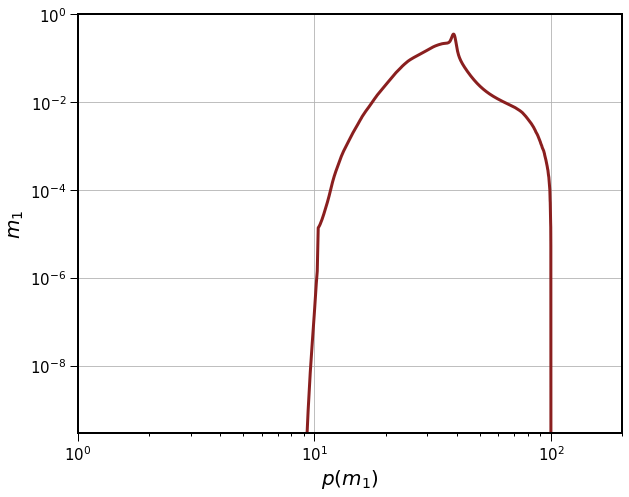

In [274]:
#Results_Gaussian_0.1eV_R=7.5_z=2.hdf5
gs = gridspec.GridSpec(1, 1,left=0.14,bottom=0.14,right=0.98,top=0.97)
fig = plt.figure(figsize=(9,7))

ax = plt.subplot(gs[0,0])

plt.plot(mass_1, mass_ppd[:][100])

plt.loglog()

ax.set_ylabel(r'$m_1$',fontsize=20)
ax.set_xlabel(r'$p(m_1)$',fontsize=20)
ax.tick_params(axis='both',width=1,length=8,labelsize=15)
ax.tick_params(axis='both',which='minor',width=1,length=3,labelsize=15)
ax.grid()

ax.set_xlim(1, 200)
#ax.set_xlim(mDM[0].value,mDM[-1].value)
ax.set_ylim(3e-10,1)


In [233]:
mass_ppd = data["ppd"]
mass_lines = data["lines"]
 
mass_1 = np.linspace(3, 100, 1000)
mass_ratio = np.linspace(0.1, 1, 500)

# Integrate the 2D PPD over mass ratio to get marginal m1 PPD
mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
        
# Get 0.05 and 0.95 percentiles at each m1
mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)

In [234]:
mass_lines['mass_1'][:]

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        2.09696892e-014, 1.92663603e-014, 1.76992180e-014],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        3.91884620e-049, 2.84993654e-049, 2.07163890e-049],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.23581420e-133, 4.82451249e-134, 1.88071284e-134],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000]])

# Try MCMC

In [286]:
import emcee
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.misc import derivative

Here just the analytics function, to try to see how the rate changes with the mass interval

In [558]:
np.vectorize
def function(m1, m2):
    
    fun = interp2d(mass_ratio , mass_1, np.transpose(mass_ppd))
    
    return fun(m2/ m1, m1)[0] * np.heaviside(m1-m2,0)
   
    

In [564]:
mass_1_short = np.linspace(45, 100, 100)
mass_2_short = np.linspace(45, 100, 100)

In [565]:
tointegrateAry = np.array([np.array([function(m1, m2 ) for m1 in mass_1_short]) for m2 in mass_2_short])

In [566]:
np.trapz(np.trapz(tointegrateAry, mass_2_short , axis = 0), mass_1_short, axis = 0 )

16.90733893873539

# Here I build the likelihood and the sampler

In [374]:
#Here I interpolate the posterior function to use it for the MCMC

np.vectorize
def PostFunct(pars):
    
    q, m1 = pars 
    
    fun = interp2d(mass_ratio , mass_1, np.transpose(mass_ppd))
    
    if q < 0.1 or q > 1 or m1 < 3 or m1 > 100:
        return -np.inf
    
    else:
        
        return np.log(fun(q, m1))

In [387]:
ndim = 2
nwalkers = 32
xopt = [0.7, 70]
p0 = np.random.randn(nwalkers,ndim)*0.1*xopt + xopt

In [388]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, PostFunct)


In [389]:
state = sampler.run_mcmc(p0, 200)

/Users/andreacaputo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [373]:
np.min(samples[:,0])

-1.0034035182040209

In [401]:
samples[100:]

array([[ 0.37257855, 54.78769468],
       [ 0.75026882, 77.84325243],
       [ 0.5374384 , 67.45268994],
       ...,
       [ 0.58846064, 19.8820745 ],
       [ 0.98187295,  6.91701058],
       [ 0.94832983,  5.24618019]])

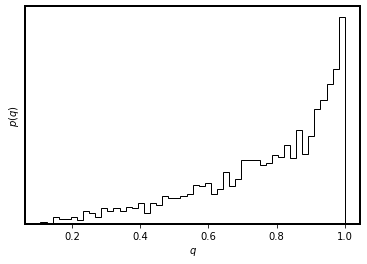

In [466]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 50, color="k", histtype="step")
plt.xlabel(r"$q$")
plt.ylabel(r"$p(q)$")
plt.gca().set_yticks([]);

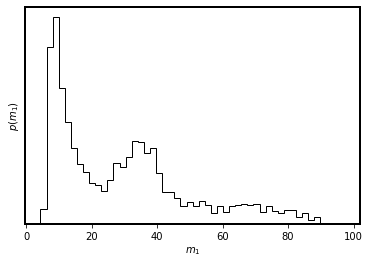

In [468]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 1], 50, color="k", histtype="step")
plt.xlabel(r"$m_1$")
plt.ylabel(r"$p(m_1)$")
plt.gca().set_yticks([]);

# Now let's use this 

In [403]:
samples_ary = samples[100:]

In [397]:
rate = np.trapz(np.trapz(mass_ppd, mass_ratio, axis=0), mass_1, axis = 0)

In [568]:
rate

24.87981296458682

In [460]:
np.savetxt("samples_ary.txt", samples_ary)

In [462]:
np.loadtxt("samples_ary.txt")

array([[ 0.37257855, 54.78769468],
       [ 0.75026882, 77.84325243],
       [ 0.5374384 , 67.45268994],
       ...,
       [ 0.58846064, 19.8820745 ],
       [ 0.98187295,  6.91701058],
       [ 0.94832983,  5.24618019]])

In [453]:
gendistrUpdated(1,1, 'EOB', 8)

array([[1.33345713e+02],
       [1.26287712e+02],
       [1.55650102e-01],
       [4.24293371e-03],
       [0.00000000e+00],
       [2.47652784e+00]])

# Now let's re-write the code for the number of events 

In [574]:
totalrateMedian = 0.13*10**(-9) 
totalrateUpper = (0.13 + 0.3)*10**(-9)
totalrateLower = (0.13 - 0.11)*10**(-9)

In [590]:
np.median(np.random.gamma(1, totalrateMedian * 1.46, 100000)) / totalrateMedian

1.0206151921006368

In [591]:
np.percentile(np.random.gamma(1, totalrateMedian * 1.46, 100000),90) / totalrateUpper

1.0132478907530331

In [592]:
np.percentile(np.random.gamma(1, totalrateMedian * 1.46, 100000),10) / totalrateLower

1.0017849878285914

# Now re-write the function for the catalogue

In [593]:
def gendistr(N,iteration,massoption,SNRth):
    

    N=int(N)
    # Define functions to store intermediate products; I haven't decided on the most convenient format for the final catalogs yet...

    massmin=50*Msol
    massmax=100*Msol

    # Largest horizon redshift; don't waste computing time above this
    zmax = 0.512
    zmin = 0.1
    # Largest comoving distance for sampling
    #??? dove la usa? -->  cdmax=astropy.cosmology.Planck15.comoving_distance(zmax).value # Mpc
    # z pdf normalization. Comoving volume at largest redshift (because comoving volume at z=0 is 0)
    # Vczhor = (astropy.cosmology.Planck15.comoving_volume(zmax)/astropy.units.Gpc**3).decompose().value #Gpc^3
    # largest merger time (yrs)
    tmax = 40
    tobs = 10
    # ground-based duty cycle
    dutycycle= 1

    data=[]
    for i in range(N):

        #Comoving distance uniform on sphere
        #while True:
        #    cd = np.sum(np.random.uniform(0, cdmax,3)**2)**0.5
        #    if cd<cdmax: break
        # Convert to redshift
        #z = astropy.cosmology.z_at_value(astropy.cosmology.Planck15.comoving_distance,cd*astropy.units.Mpc )
        # Convert to luminosity distance


        z = np.random.uniform(zmin,zmax)
        dl = distL(z)

        # Mass spectrum
        if massoption=='log': # Log flat distribution in both masses
            bothm=10**np.random.uniform(np.log10(massmin),np.log10(massmax),2)
            m1= max(bothm)
            m2= min(bothm)
            Rate = 57*10**(-9)
        
        if massoption == 'EOB':
            index = np.random.choice(len(eobdata))
            m1 = Msol*eobdata[index][0]
            m2 = Msol*eobdata[index][1]
            Rate = 0.13*10**(-9)
        
        if massoption == 'PHEN':
            index = np.random.choice(len(Phendata))
            m1 = Msol* Phendata[index][0]
            m2 = Msol*Phendata[index][1]
            Rate = 0.13*10**(-9)
            
        if massoption == 'NR':
            index = np.random.choice(len(NRdata))
            m1 = Msol*NRdata[index][0]
            m2 = Msol*NRdata[index][1]
            Rate = 0.13*10**(-9)
        
        if massoption=='powerlaw': # Power law with spectral index alpha in primary; uniform in secondary
            alpha=-2.3
            m1 = (massmin**(alpha+1.)+np.random.uniform(0.,1.)*(massmax**(alpha+1.)-massmin**(alpha+1.)))**(1./(alpha+1.))
            m2 = np.random.uniform(massmin,m1)
            Rate = 0.13*10**(-9)
                
        # Sky-location, inclination, polarization, initial phase
        cosiota = random.uniform(-1.,1.)
        psi = random.uniform(0,2*pi)
        costheta=random.uniform(-1.,1.)
        phi=random.uniform(0,2*pi)
        iota=np.arccos(cosiota)
        theta=np.arccos(costheta)
        #phic = np.random.uniform(0,2.*np.pi)
        
        # Merger time
        tmerger=np.random.uniform(1*year,41*year)
        
        #fmin=np.random.uniform(1e-5,0.01)
        fmin=findFmin(tmerger,m1,m2)
        Fmax= getfmax(m1*(1+z),m2*(1+z),fmin/(1+z),tobs*year)  #fmax(m1,m2,fmin,tobs*year)
        #Fmax = 1 #Fmax=1
        snr=np.sqrt(dutycycle)*SNR(iota,psi,theta,phi,fmin/(1+z),Fmax,m1*(1+z),m2*(1+z),dl)


        dVcdz = cosmo.comoving_volume(z).value 
        rateSampling = np.random.gamma(1, Rate * 1.46) #np.random.normal(Rate, 0.3e-9)#1 / np.random.gamma(1, 1/ Rate)
        
        integralbulk = rateSampling * tmax * (zmax-zmin) * dVcdz   *np.heaviside(snr-SNRth,0) * (1./(1.+z))
            
        data.append(np.array([m1,m2,z,fmin,integralbulk,snr]))

    return np.array(data).T

In [596]:
def consolidatedistr(Nsingle,iterations,massoption,SNRth):

    Nsingle = int(Nsingle)
    iterations = int(iterations)

    Ntot = Nsingle*iterations
    data=[]
    for it in range(0,iterations):
        data.append(gendistr(Nsingle,it,massoption,SNRth))

    data=np.array(data)

    #[m1,m2,z,pdetLIGO,pdetCE,tmerger,SNR4,SNR10,integralbulk]

    m1 = np.concatenate(data[:,0])
    m2 = np.concatenate(data[:,1])
    z = np.concatenate(data[:,2])
    #pdetLIGO = np.concatenate(data[:,3])
    #pdetCE = np.concatenate(data[:,4])
    #tmerger = np.concatenate(data[:,3])
    fmin = np.concatenate(data[:,3])
    #SNR4 = np.concatenate(data[:,6])
    #SNR10 = np.concatenate(data[:,7])
    integralbulk = np.concatenate(data[:,4])
    SNR10 = np.concatenate(data[:,5])

    return m1,m2,z,fmin,integralbulk,SNR10

In [597]:
def NeventsNew(bigdata,massoption):

    # bigdata is the output of consolidatedistr
    m1,m2,z,fmin,integralbulk,SNR10 = bigdata #consolidatedistr(Nsingle,iterations)

    Ntot = len(m1)
     
    montecarlo_contributions = integralbulk / Ntot
        
    return np.sum(montecarlo_contributions)
        


In [ ]:
Nevents(consolidatedistr(10**5,1,'NR',8),'NR')

# Old Stuff

In [570]:
def gendistrUpdated(N,iteration,massoption,SNRth):
    

    N=int(N)
    # Define functions to store intermediate products; I haven't decided on the most convenient format for the final catalogs yet...

    massmin=50*Msol
    massmax=100*Msol

    # Largest horizon redshift; don't waste computing time above this
    zmax = 0.512
    zmin = 0.1
    # Largest comoving distance for sampling
    #??? dove la usa? -->  cdmax=astropy.cosmology.Planck15.comoving_distance(zmax).value # Mpc
    # z pdf normalization. Comoving volume at largest redshift (because comoving volume at z=0 is 0)
    # Vczhor = (astropy.cosmology.Planck15.comoving_volume(zmax)/astropy.units.Gpc**3).decompose().value #Gpc^3
    # largest merger time (yrs)
    tmax = 40
    tobs = 10
    # ground-based duty cycle
    dutycycle= 1

    data=[]
    for i in range(N):

        #Comoving distance uniform on sphere
        #while True:
        #    cd = np.sum(np.random.uniform(0, cdmax,3)**2)**0.5
        #    if cd<cdmax: break
        # Convert to redshift
        #z = astropy.cosmology.z_at_value(astropy.cosmology.Planck15.comoving_distance,cd*astropy.units.Mpc )
        # Convert to luminosity distance


        z = np.random.uniform(zmin,zmax)
        dl = distL(z)

        # Mass spectrum
        if massoption=='log': # Log flat distribution in both masses
            bothm=10**np.random.uniform(np.log10(massmin),np.log10(massmax),2)
            m1= max(bothm)
            m2= min(bothm)
            norm = 1
        
        if massoption == 'EOB':
            index = np.random.choice(len(eobdata))
            m1 = Msol*eobdata[index][0]
            m2 = Msol*eobdata[index][1]
            norm = 1
        
        if massoption == 'PHEN':
            index = np.random.choice(len(Phendata))
            m1 = Msol* Phendata[index][0]
            m2 = Msol*Phendata[index][1]
            Rate = 0.13*10**(-9)
            
        if massoption == 'NR':
            index = np.random.choice(len(NRdata))
            m1 = Msol*NRdata[index][0]
            m2 = Msol*NRdata[index][1]
            norm = 1
        
        if massoption=='powerlaw': # Power law with spectral index alpha in primary; uniform in secondary
            alpha=-2.3
            m1 = (massmin**(alpha+1.)+np.random.uniform(0.,1.)*(massmax**(alpha+1.)-massmin**(alpha+1.)))**(1./(alpha+1.))
            m2 = np.random.uniform(massmin,m1)
            norm = 1
            
        if massoption =='broken':
            index = np.random.choice(len(samples_ary))
            m1 = Msol* samples_ary[index][1]
            m2 = Msol * samples_ary[index][1] * samples_ary[index][0]
            norm = 1
            
        if massoption =='AGN':
            index = np.random.choice(len(samples_ary))
            m1 = Msol* samples_ary[index][1]
            m2 = Msol * samples_ary[index][1] * samples_ary[index][0]
            
            if m1 <= 45 *Msol:
                norm = 0
            else:
                norm = 1
                
        if massoption =='AGN':
            index = np.random.choice(len(samples_ary))
            m1 = Msol* samples_ary[index][1]
            m2 = Msol * samples_ary[index][1] * samples_ary[index][0]
            
            if m1 <= 45 *Msol:
                norm = 0
            else:
                norm = 1
            
                
        # Sky-location, inclination, polarization, initial phase
        cosiota = random.uniform(-1.,1.)
        psi = random.uniform(0,2*pi)
        costheta=random.uniform(-1.,1.)
        phi=random.uniform(0,2*pi)
        iota=np.arccos(cosiota)
        theta=np.arccos(costheta)
        #phic = np.random.uniform(0,2.*np.pi)
        
        # Merger time
        tmerger=np.random.uniform(1*year,41*year)
        
        #fmin=np.random.uniform(1e-5,0.01)
        fmin=findFmin(tmerger,m1,m2)
        Fmax= getfmax(m1*(1+z),m2*(1+z),fmin/(1+z),tobs*year)  #fmax(m1,m2,fmin,tobs*year)
        #Fmax = 1 #Fmax=1
        snr=np.sqrt(dutycycle)*SNR(iota,psi,theta,phi,fmin/(1+z),Fmax,m1*(1+z),m2*(1+z),dl)


        dVcdz = cosmo.comoving_volume(z).value 
            
        integralbulk = norm * tmax * (zmax-zmin) * dVcdz   *np.heaviside(snr-SNRth,0) * (1./(1.+z))

        data.append(np.array([m1,m2,z,fmin,integralbulk,snr]))

    return np.array(data).T



In [433]:
Msol* samples_ary[10][0] * samples_ary[10][1]

42.266204658503135

In [571]:
def consolidatedistrUpdated(Nsingle,iterations,massoption,SNRth):

    Nsingle = int(Nsingle)
    iterations = int(iterations)

    Ntot = Nsingle*iterations
    data=[]
    for it in range(0,iterations):
        data.append(gendistrUpdated(Nsingle,it,massoption,SNRth))

    data=np.array(data)

    #[m1,m2,z,pdetLIGO,pdetCE,tmerger,SNR4,SNR10,integralbulk]

    m1 = np.concatenate(data[:,0])
    m2 = np.concatenate(data[:,1])
    z = np.concatenate(data[:,2])
    #pdetLIGO = np.concatenate(data[:,3])
    #pdetCE = np.concatenate(data[:,4])
    #tmerger = np.concatenate(data[:,3])
    fmin = np.concatenate(data[:,3])
    #SNR4 = np.concatenate(data[:,6])
    #SNR10 = np.concatenate(data[:,7])
    integralbulk = np.concatenate(data[:,4])
    SNR10 = np.concatenate(data[:,5])

    return m1,m2,z,fmin,integralbulk,SNR10


In [572]:
def NeventsUpdated(bigdata,massoption,rateinterval):

    # bigdata is the output of consolidatedistr
    m1,m2,z,fmin,integralbulk,SNR10 = bigdata #consolidatedistr(Nsingle,iterations)

    Ntot = len(m1)

    # Intrisinc merger rate from LIGO O2 catalog. Use the numbers reported in Sec 4 of 1811.12940, which averages over the two pipelines.
    totalrate={}
    if massoption=='powerlaw':
        totalrate['median'] =  57*10**(-9)
        totalrate['upper'] = (57 + 40)*10**(-9)
        totalrate['lower'] = (57. - 25.)*10**(-9)
    if massoption=='log':
        totalrate['median'] = 0.13*10**(-9) #19.*10**(-9)
        totalrate['upper'] = (19. + 13.)*10**(-9)
        totalrate['lower'] = (19. - 8.2)*10**(-9)
        
    if massoption=='EOB' or massoption=='NR' or massoption=='PHEN':
        totalrate['median'] = 0.13*10**(-9) #19.*10**(-9)
        totalrate['upper'] = (0.13 + 0.3)*10**(-9)
        totalrate['lower'] = (0.13 - 0.11)*10**(-9)
        
    if massoption=='broken' or massoption=='AGN':
        totalrate['median'] = rate*10**(-9) #19.*10**(-9)
        totalrate['upper'] = (19. + 13.)*10**(-9)
        totalrate['lower'] = (19. - 8.2)*10**(-9)

    
    montecarlo_contributions = totalrate[rateinterval] * integralbulk / Ntot
    

    return np.sum(montecarlo_contributions)


In [457]:
rate

24.87981296458682

In [497]:
NeventsUpdated(consolidatedistrUpdated(10**5,1,'broken',8),'broken','median')

66.01046378697276

In [ ]:
NeventsUpdated(consolidatedistrUpdated(10**5,1,'broken',8),'broken','median')

In [573]:
NeventsUpdated(consolidatedistrUpdated(10**5,1,'AGN',8),'AGN','median')

60.2394055864585

In [499]:
NeventsUpdated(consolidatedistrUpdated(10**5,1,'AGN',8),'AGN','median')

44.99826109992512